Инициализация преднастроенных нейросетевых моделей

In [ ]:
from torchvision import models

alexNet = {
    # https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
    'model': models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    'weights': models.AlexNet_Weights.DEFAULT,
    'preprocess': models.AlexNet_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[1].in_features
}

resNet50 = {
    # https://arxiv.org/abs/1512.03385
    'model': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'weights': models.ResNet50_Weights.DEFAULT,
    'preprocess': models.ResNet50_Weights.DEFAULT.transforms(),
    'output_layer': 'fc',
    'in_features': lambda model: model.fc.in_features
}

denseNet = {
    # https://arxiv.org/abs/1608.06993
    'model': models.densenet201(weights=models.DenseNet201_Weights.DEFAULT),
    'weights': models.DenseNet201_Weights.DEFAULT,
    'preprocess': models.DenseNet201_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[0].in_features
}

mobileNetV3_small = {
    # https://arxiv.org/abs/1905.02244
    'model': models.mobilenet_v3_small(weights=models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT),
    'weights': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT,
    'preprocess': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[0].in_features
}

swinT = {
    # https://arxiv.org/abs/2103.14030
    'model': models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT),
    'weights': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT,
    'preprocess': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT.transforms(),
    'output_layer': 'head',
    'in_features': lambda model: model.head.in_features
}


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 66.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.7MB/s]
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:04<00:00, 16.4MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 45.0MB/s]
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 95.1MB/s]


Далее необходимо определиться с вычислительной подсистемой (CPU или GPU).

In [ ]:
import torch

gpu = 'has' if torch.cuda.is_available() else 'has no'
print(f'Current environment {gpu} GPU support')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!lscpu
print(f'GPU count = {torch.cuda.device_count() if torch.cuda.is_available() else "0"}')

for model in [resNet50, alexNet, denseNet, mobileNetV3_small, swinT]:
    model['model'].to(device)
    model['preprocess'].to(device)
    model['model'].eval()

Current environment has no GPU support
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                          

Вспомогательные функции

In [ ]:
import os
import time
import copy
import math

import typing
from typing import Callable
from functools import partial

import numpy
import pandas
from pandas.core.arrays import boolean
import matplotlib.pyplot as plt
from requests import get

from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToPILImage, Compose, Resize, CenterCrop
from torchvision.io import read_image


strip_chars = ' \t'
tmp_file_name = 'tmp_file_name_for_image_download'

to_image = ToPILImage()


def classify(dataset: Dataset,
                preprocess: typing.Callable[[Tensor],Tensor],
                num_per_row: int, single_size: float,
                labels: typing.List[str],
                model_labels: typing.List[str] = None,
                model: typing.Callable[[Tensor], Tensor] = None,
                debug: typing.Any = False,
                num_of_classes: int = 1,
                vspace: float = 0.3
             ) -> None:
    num = len(dataset)
    fig, axs = plt.subplots(math.ceil(num/num_per_row), num_per_row, figsize=(
        single_size*num_per_row, (single_size + vspace)*(math.ceil(num/num_per_row))),
        sharex=True, sharey=True)
    for i in range(0, len(dataset)):
        try:
            image, label = dataset[i]
            pred = None

            if model is not None and model_labels is not None:
                start_time = time.perf_counter_ns()
                score = model(image.unsqueeze(0)).detach().squeeze(0).softmax(0)
                pred_index = numpy.flip(score.detach().cpu().argsort().numpy())[0]
                end_time = time.perf_counter_ns()
                pred = f'Detector: {(end_time - start_time) / 1_000_000:.0f}ms\n{model_labels[pred_index]}[{score[pred_index].item()*100:.0f}%]'

            loc_fig = axs[i//num_per_row, i % num_per_row]
            loc_fig.imshow(to_image(preprocess(image)))
            title =f'\nActual: {labels[label]}[{label}]\n{pred}'
            loc_fig.title.set_text(title)
        except Exception as ex:
            if debug:
                raise ex
            print(f'Image {i} is failed to load: {str(ex)}')

    fig.subplots_adjust(wspace=0.3)
    plt.show()


def denormalize(dataset: Dataset, trans: typing.Any) -> Callable[[Tensor], Tensor]:
    image, label = dataset[0]
    std = torch.as_tensor(trans.std, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    mean = torch.as_tensor(trans.mean, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    return lambda img: img*std + mean


class UrlDataset(Dataset):

    def __init__(self, file: str, to_device, transform = None) -> None:
        self.file = file
        self.transform = transform
        self.dataset = pandas.read_csv(file, sep=';')
        self.classes = self.dataset['label'].unique()
        self.classes.sort()
        self.class_to_index = {self.classes[i] : i for i in range(len(self.classes))}
        self.device = to_device

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, str]:
        url = self.dataset.iloc[index]['url'].strip(strip_chars)
        with open(tmp_file_name, 'wb') as file:
            file.write(get(url).content)
        image = read_image(tmp_file_name).to(self.device)
        label = self.class_to_index[self.dataset.iloc[index]['label']]
        if self.transform:
            return self.transform(image), label
        return image, label


def train_model(model, dataloader: DataLoader, device: torch.device,
                critery, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    best_epoch = -1

    process = {'train': {'loss': [], 'accuracy': []}, 'validate': {'loss': [], 'accuracy': []}}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_loss = 0.0
        epoch_acc = 0.0
        for item in dataloader:
            if item['train'] == True:
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            dataset_size = 0
            for inputs, labels in item['loader']:
                dataset_size = dataset_size + 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(item['train'] == True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = critery(outputs, labels)
                    if item['train'] == True:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if item['train'] == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.detach().cpu().double() / dataset_size

            if item['train'] == True:
                ptype = 'train'
            else:
                ptype = 'validate'

            process[ptype]['loss'].append(epoch_loss)
            process[ptype]['accuracy'].append(epoch_acc)

            print(f'[{epoch}][train={item["train"]}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if item['train'] == True and 1/epoch_loss > best_loss:
                best_loss = 1/epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {1/best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, process


Пример описания данных для классификации

В практическом задании набор данных (датасет) формализуется в виде CSV-файла, содержащего URL изображения из интернета и вручную назначенных меток объектов (названий классов), к которому каждое изображение относится.

In [ ]:
%%writefile train.csv
label;url
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_1.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_3.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_2.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_4.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_5.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_6.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_7.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_8.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_9.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_10.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_11.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_12.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_13.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_14.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_15.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_16.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_17.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_18.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_19.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_20.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_21.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_22.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_23.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_24.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_25.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_26.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_27.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_28.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_29.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_30.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_31.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_32.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_33.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_34.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_35.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_36.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_37.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_38.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_39.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_40.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_41.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_42.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_43.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_44.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_45.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_46.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_47.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_48.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_49.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_50.jpg?raw=true

Overwriting train.csv


In [ ]:
%%writefile test.csv
label;url
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_1.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_3.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_2.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_4.jpg?raw=true
Tractor-hydrodrill;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_5.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_26.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_27.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_28.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_29.jpg?raw=true
mobile-crane;https://github.com/Smoooky42/neural_network_coursework/blob/main/pr1_dataset/train.csv_image_30.jpg?raw=true

Overwriting test.csv


----------------------------------------------------------------------
Model: SwinTransformer
Number of parameters: 28288354
------------------------------ Train dataset ------------------------------
Image 37 is failed to load: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0


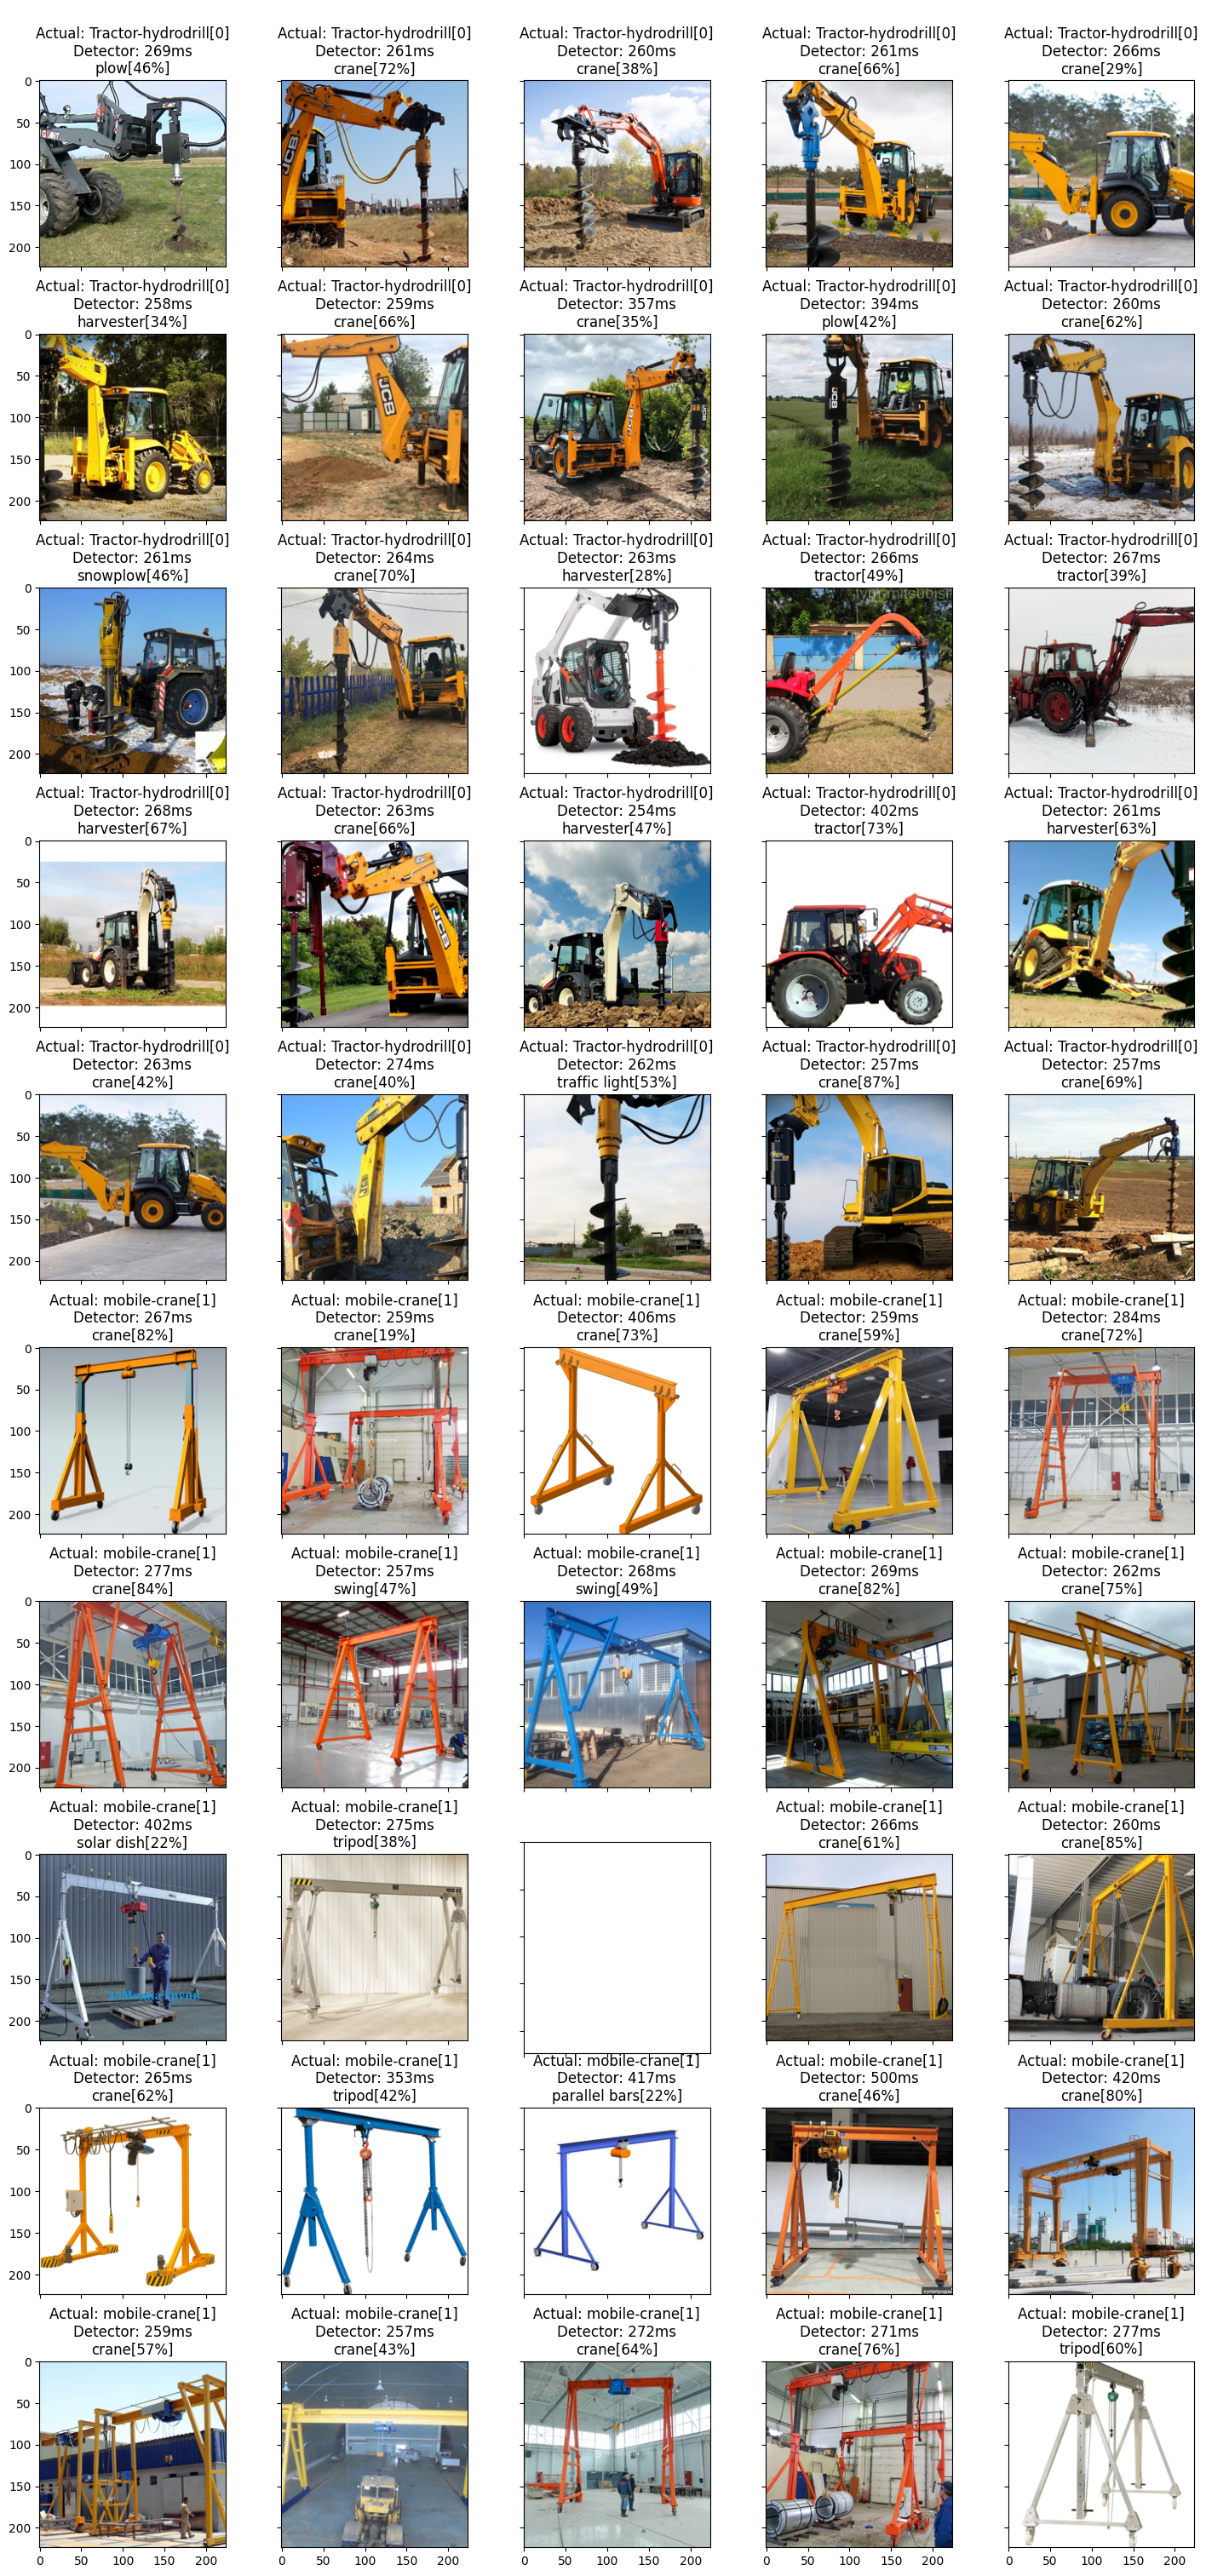

------------------------------ Test dataset ------------------------------


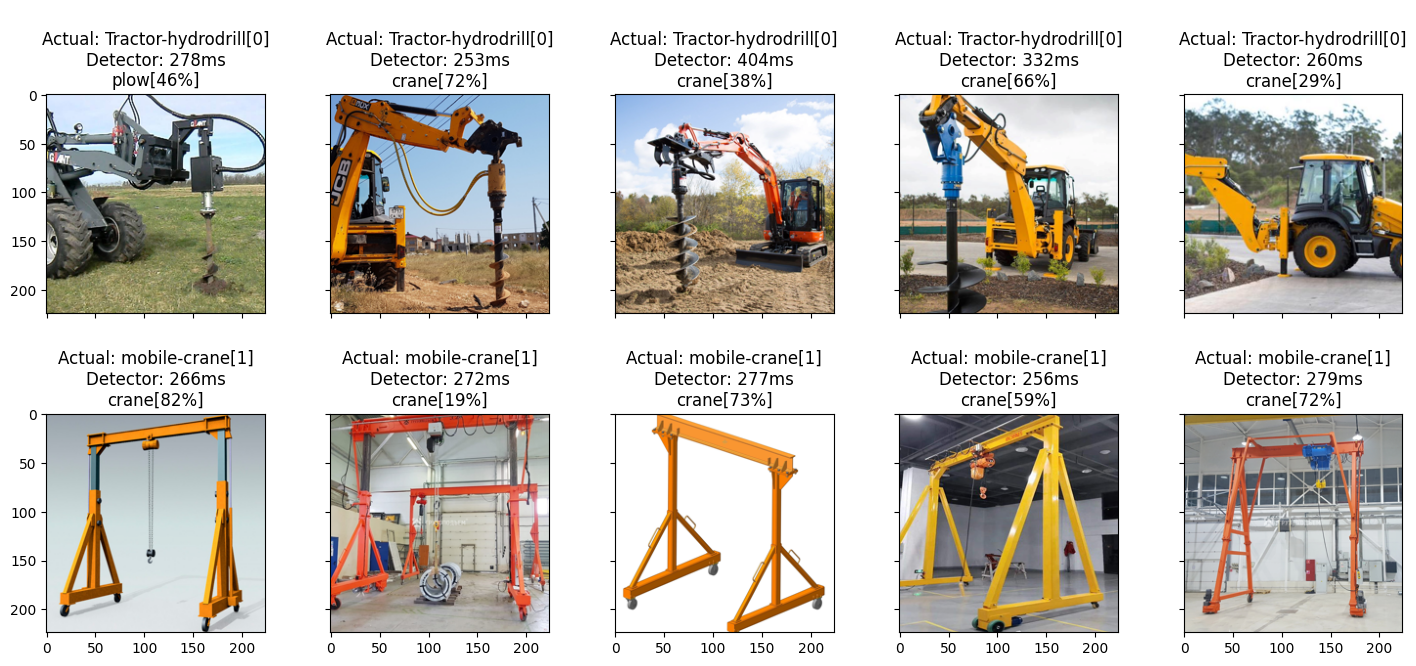

In [ ]:
transform = model['preprocess']
train = UrlDataset("train.csv", device, transform)
test = UrlDataset('test.csv', device, transform)

num_per_row = 5
single_size = 3.5
vspace = 0.3

print('-'*70)
print(f'Model: { model["model"].__class__.__name__}')
print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

print('-'*30  + ' Train dataset ' + '-'*30)
classify(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = train.classes, model=model['model'], model_labels=model['weights'].meta["categories"])
print('-'*30  + ' Test dataset ' + '-'*30)
classify(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = test.classes, model=model['model'], model_labels=model['weights'].meta["categories"])